# Predicting Financial Distress Notebook
- Dataset can be found at: https://www.kaggle.com/c/GiveMeSomeCredit
    - Contains historical data on 150,000 borrowers
        - Labels are binary: defaulted or didn't default (SeriousDlqin2yrs)
    - Goal is to predict default risk on holdout set

In [1]:
# Import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from collections import Counter

import seaborn as sns

In [2]:
# Read CSV
df = pd.read_csv('../data/cs-training.csv')
df = df.drop('Unnamed: 0', axis=1)

In [3]:
#df = df.dropna()

In [4]:
# Clean column names
cleanCol = []
for i in range(len(df.columns)):
    cleanCol.append(df.columns[i].replace('-', 'to'))
    
df.columns = cleanCol

In [5]:
# Calculate std dev values
def findStd(series,num):
    mean = series.mean()
    stdDev = series.std()
    std_pos = mean + num*stdDev
    std_neg = mean - num*stdDev
    
    stdValues = {
        'std+': std_pos,
        'std-': std_neg
    }
    
    return stdValues

In [6]:
def standardizeValues(dfColumn,stdRet,columnName,classifier='mean',compareColumn='N/A',lookupTable='N/A'):
    if classifier == 'lookup':
        df.loc[dfColumn.isnull(),columnName] = compareColumn.map(lookupTable)
        df.loc[dfColumn>stdRet['std+'],columnName] = compareColumn.map(lookupTable)
        df.loc[dfColumn<stdRet['std-'],columnName] = compareColumn.map(lookupTable)
    elif classifier == 'median':
        df.loc[dfColumn.isnull(),columnName] = dfColumn.median()
        df.loc[dfColumn>stdRet['std+'],columnName] = dfColumn.median()
        df.loc[dfColumn<stdRet['std-'],columnName] = dfColumn.median()
    else:
        df.loc[dfColumn.isnull(),columnName] = dfColumn.mean()
        df.loc[dfColumn>stdRet['std+'],columnName] = dfColumn.mean()
        df.loc[dfColumn<stdRet['std-'],columnName] = dfColumn.mean()

In [7]:
def standardizePlaceholders(dfColumn,columnName,classifier='mean'):
    if classifier == 'median':
        df.loc[dfColumn==98,columnName] = dfColumn.median()
        df.loc[dfColumn==96,columnName] = dfColumn.median()
        
    else:
        df.loc[dfColumn==98,columnName] = dfColumn.mean()
        df.loc[dfColumn==98,columnName] = dfColumn.mean()

In [8]:
# Get std deviation and replace outliers
ageStd = findStd(df.age,3)
standardizeValues(df.age,ageStd,'age')
df.age = df.age.astype(int)

In [9]:
# Drop NAN from OG DF
df_MI = df[['age','MonthlyIncome']]

In [10]:
df_MIsansNAN = df_MI.dropna(axis=0, how='any')

# Remove Income Outliers outside of 3 STD
df_MIsansNAN_std = df_MIsansNAN[np.abs(df_MIsansNAN.MonthlyIncome-df_MIsansNAN.MonthlyIncome.mean())<=(3*df_MIsansNAN.MonthlyIncome.std())]

In [11]:
# Create lookup table for mean per age
ageSalaryLookup = pd.DataFrame(df_MIsansNAN_std.groupby(['age']).MonthlyIncome.mean())

In [12]:
# Find all values 3x std
incomeStd = findStd(df_MIsansNAN_std.MonthlyIncome,3)
standardizeValues(df.MonthlyIncome,incomeStd,'MonthlyIncome','lookup',df.age,ageSalaryLookup.MonthlyIncome)

In [13]:
# Define deviation and replace outliers
revLnStd = {'std+': 2, 'std-': 0}
standardizeValues(df.RevolvingUtilizationOfUnsecuredLines,revLnStd,'RevolvingUtilizationOfUnsecuredLines','median')

In [14]:
# Replace placeholders with the median
standardizePlaceholders(df.NumberOfTime30to59DaysPastDueNotWorse,'NumberOfTime30to59DaysPastDueNotWorse','median')

In [15]:
debtRatioStd = {'std+': 2, 'std-': 0}
standardizeValues(df.DebtRatio,debtRatioStd,'DebtRatio','median')

In [16]:
# Replace placeholders with the median
standardizePlaceholders(df.NumberOfTimes90DaysLate,'NumberOfTimes90DaysLate','median')
df.NumberOfTimes90DaysLate = df.NumberOfTimes90DaysLate.astype(int)

In [17]:
# Replace placeholders with the median
standardizePlaceholders(df.NumberOfTime60to89DaysPastDueNotWorse,'NumberOfTime60to89DaysPastDueNotWorse','median')
df.NumberOfTime60to89DaysPastDueNotWorse = df.NumberOfTime60to89DaysPastDueNotWorse.astype(int)

In [18]:
# Drop NAN from OG DF
df_D = df[['NumberOfDependents']]
df_DsansNAN = df_D.dropna(axis=0, how='any')

In [19]:
# Define deviation and replace outliers
depStd = {'std+': df.NumberOfDependents.max(), 'std-': df.NumberOfDependents.min()}
standardizeValues(df.NumberOfDependents,depStd,'NumberOfDependents','median')

In [20]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.066840,0.319924,52.281313,0.245353,0.344349,6114.110913,8.452760,0.090293,1.018240,0.064707,0.737413
std,0.249746,0.355123,14.748528,0.697231,0.263902,3336.776302,5.145951,0.485107,1.129771,0.329788,1.107021
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3800.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154178,52.000000,0.000000,0.366506,5900.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.552810,63.000000,0.000000,0.405709,7405.250000,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,1.998676,96.000000,13.000000,2.000000,20087.000000,58.000000,17.000000,54.000000,11.000000,20.000000


### Add MonthlyCosts column

In [21]:
# write function to multiply DebtRatio by MonthlyIncome and put the result in a new column
def add_monthlycosts_column(dataframe):
    dataframe_copy = dataframe.copy()
    dataframe_copy['MonthlyCosts'] = dataframe_copy['DebtRatio'] * dataframe_copy['MonthlyIncome']
    
    return dataframe_copy

### Add IncomePerDependent column

In [22]:
# write function to divide MonthlyIncome by (NumberOfDependents + 1) and put the result in a new column
def add_incomeperdependent_column(dataframe):
    dataframe_copy = dataframe.copy()
    dataframe_copy['IncomePerDependent'] = dataframe_copy['MonthlyIncome'] / (dataframe_copy['NumberOfDependents'] + 1)
    
    return dataframe_copy

### Add NumTimesPastDue column

In [23]:
# write function to divide MonthlyIncome by (NumberOfDependents + 1) and put the result in a new column
# the function also drops the original columns
def add_numtimespastdue_column(dataframe):
    dataframe_copy = dataframe.copy()
    dataframe_copy['NumTimesPastDue'] = (dataframe_copy['NumberOfTime30to59DaysPastDueNotWorse'] +
                                         dataframe_copy['NumberOfTime60to89DaysPastDueNotWorse'] +
                                         dataframe_copy['NumberOfTimes90DaysLate'])
    
    dataframe_copy = dataframe_copy.drop('NumberOfTime30to59DaysPastDueNotWorse', axis=1)
    dataframe_copy = dataframe_copy.drop('NumberOfTime60to89DaysPastDueNotWorse', axis=1)
    dataframe_copy = dataframe_copy.drop('NumberOfTimes90DaysLate', axis=1)
    
    return dataframe_copy

### Function to write indicator variable columns:

In [24]:
# define function to label rows with high monthly income with a 1 (in a new column)
def add_indicator_column(dataframe, threshold, column_name, direction='above'):
    dataframe_copy = dataframe.copy()
    labels = []
    if direction == 'above':
        for index, row in dataframe_copy.iterrows():
            value = row[column_name]
            if value >= threshold:
                labels.append(float(1))
            elif value < threshold:
                labels.append(float(0))
            else:
                print('Error in add_indicator_column(): Base case reached')
    elif direction == 'below':
        for index, row in dataframe_copy.iterrows():
            value = row[column_name]
            if value <= threshold:
                labels.append(float(1))
            elif value > threshold:
                labels.append(float(0))
            else:
                print('Error in add_indicator_column(): Base case reached')
    if len(dataframe_copy) == len(labels):
        dataframe_copy[(str(column_name) + '_' + str(direction) + str(threshold))] = pd.Series(labels)
    else:
        print('Error in add_indicator_column(): Missing labels')
    return dataframe_copy

In [25]:
# outside of function

# feature engineering steps
# dataframe_copy = add_incomeoverrevolving_column(dataframe_copy)


df = add_monthlycosts_column(df)

df = add_incomeperdependent_column(df)
df = add_numtimespastdue_column(df)
df = add_indicator_column(df, 10000, 'MonthlyIncome', direction='above')
df = add_indicator_column(df, 5, 'NumTimesPastDue', direction='below')
df = add_indicator_column(df, 21, 'age', direction='below')
df = add_indicator_column(df, 65, 'age', direction='above')
    
# dropping multicollinear features
df = df.drop('DebtRatio', axis=1)

### Check for multicollinearity
- new features, new possible multicollinearities

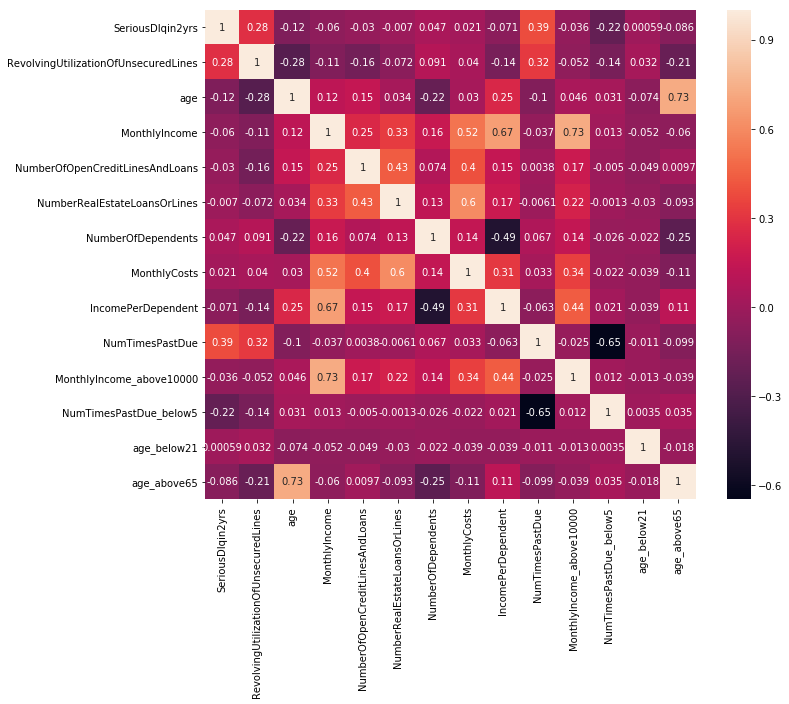

In [26]:
plt.figure(figsize=(11,9))
sns.heatmap(df.corr(), annot=True, fmt=".2g")

## Step 11: Fit Scaler and Transform Data


In [27]:
X = df.drop('SeriousDlqin2yrs', axis=1)
y = df.SeriousDlqin2yrs

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [29]:
# fit StandardScaler and use it to transform both training and testing data
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler().fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Step 12: Fit Model and Make Predictions

In [30]:
# instantiate logistic regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

In [31]:
# fit the model on the cleaned training data
model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
# make predictions on training set (want to evaluate model performance on training set first, then testing set)
class_predictions_training = model.predict(X_train_scaled)
probability_predictions_training = model.predict_proba(X_train_scaled)

In [33]:
class_predictions_training

array([0, 0, 0, ..., 0, 0, 0])

In [34]:
probability_predictions_training[:5,:]

array([[0.98066925, 0.01933075],
       [0.981957  , 0.018043  ],
       [0.98603725, 0.01396275],
       [0.85165653, 0.14834347],
       [0.96912701, 0.03087299]])

#### What is returned from ```model.predict_proba()``` is an array with the probability of each class for a given row
- negative class (no default in our case) is in the first column of the array, positive in the second
- ```roc_curve()``` function takes at least two arguments:
    - first, the true labels
    - second, the probability of the positive class (defaulted, in our case)

In [35]:
# y_train has the true labels, however probability_predictions has both negative and positive class in the array
# to isolate positive predictions, we will slice the array to include only second column
positive_probability_predictions_training = probability_predictions_training[:,1]
positive_probability_predictions_training

array([0.01933075, 0.018043  , 0.01396275, ..., 0.02386315, 0.03007668,
       0.04443507])

In [36]:
# run roc_curve
from sklearn.metrics import roc_curve, roc_auc_score

fpr_training, tpr_training, thresholds_training = roc_curve(y_train, positive_probability_predictions_training)

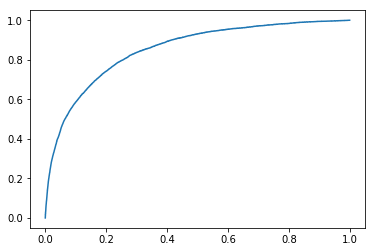

In [37]:
# plot curve for training data
plt.plot(fpr_training, tpr_training)

In [38]:
# print AUC for training data
AUC_score_training = roc_auc_score(y_train, positive_probability_predictions_training)
print('AUC: ', AUC_score_training)

AUC:  0.8519852846801945


## Step 13: Evaluate Model on Testing Set

In [39]:
# same as above, but on testing set
probability_predictions_testing = model.predict_proba(X_test_scaled)
positive_probability_predictions_testing = probability_predictions_testing[:,1]
fpr_testing, tpr_testing, thresholds_testing = roc_curve(y_test, positive_probability_predictions_testing)

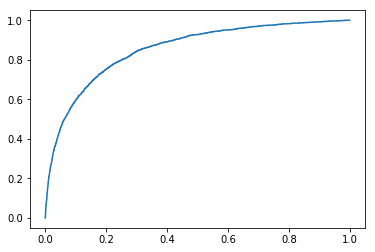

In [40]:
plt.plot(fpr_testing, tpr_testing)

In [41]:
AUC_score_testing = roc_auc_score(y_test, positive_probability_predictions_testing)
print('AUC: ', AUC_score_testing)

AUC:  0.8534518749233954


In [54]:
coefficients = list(model.coef_)
X_cols = list(X_train.columns)

for i in range(0, len(coefficients[0])):
    print(X_cols[i], 'feature strength: ', coefficients[0][i])
    print('---------\n')

RevolvingUtilizationOfUnsecuredLines feature strength:  0.6687446609493983
---------

age feature strength:  -0.2538132101358294
---------

MonthlyIncome feature strength:  -0.27315305497107933
---------

NumberOfOpenCreditLinesAndLoans feature strength:  0.07740657357986602
---------

NumberRealEstateLoansOrLines feature strength:  0.043716095656293065
---------

NumberOfDependents feature strength:  0.06734002967525765
---------

MonthlyCosts feature strength:  0.16196704772035653
---------

IncomePerDependent feature strength:  0.07248262797917031
---------

NumTimesPastDue feature strength:  0.693916132214379
---------

MonthlyIncome_above10000 feature strength:  -0.005152568201326179
---------

NumTimesPastDue_below5 feature strength:  0.16364709943526304
---------

age_below21 feature strength:  -0.021582720536621088
---------

age_above65 feature strength:  -0.026895980872582492
---------



In [52]:
model.coef_

array([[ 0.66874466, -0.25381321, -0.27315305,  0.07740657,  0.0437161 ,
         0.06734003,  0.16196705,  0.07248263,  0.69391613, -0.00515257,
         0.1636471 , -0.02158272, -0.02689598]])

## Step 14: Hypertune Model Parameters

## Step 15: Try Other Models